## **Importing Libraries**

In [70]:
# Importing Libraries

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

import pandas as pd

from scipy.io import loadmat

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import EfficientNetB4
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.layers.core import Activation, Dropout, Lambda, Dense
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.layers import Flatten, Input
from keras.optimizers import Adam
from keras.models import Model
from keras import regularizers

## **Downloading and Extracting the Datasets**

In [2]:
# Reading IMDb Data
!wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar

--2023-04-26 17:08:32--  https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7012157440 (6.5G) [application/x-tar]
Saving to: ‘imdb_crop.tar’

imdb_crop.tar         0%[                    ] 200.00K   315KB/s               ^C


In [3]:
# Reading Wiki Data
!wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar

--2023-04-26 17:08:38--  https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 811315200 (774M) [application/x-tar]
Saving to: ‘wiki_crop.tar’

wiki_crop.tar       100%[===================>] 773.73M  14.8MB/s    in 54s     

2023-04-26 17:09:34 (14.2 MB/s) - ‘wiki_crop.tar’ saved [811315200/811315200]



In [4]:
# Extracting the Data
!tar -xf imdb_crop.tar
!tar -xf wiki_crop.tar

## **Loading the Data**

In [5]:
# Loading the data
imdb_data = loadmat('imdb_crop/imdb.mat')
wiki_data = loadmat('wiki_crop/wiki.mat')

#imdb = imdb_data['imdb']
wiki = wiki_data['wiki']

## **Data Preprocessing**

In [ ]:
# Processing the IMDb Dataset

imdb_path = []
imdb_age = []
imdb_genders = []
imdb_len = 460723

count = 0
f = True

for i in range(imdb_len):
    imdb_dob = int(imdb[0][0][0][0][i]/365)
    imdb_photo_date = imdb[0][0][1][0][i]
    imdb_full_path = imdb[0][0][2][0][i][0]
    imdb_gender = imdb[0][0][3][0][i]
    FaceScore1 = imdb[0][0][6][0][i]
    FaceScore2 = imdb[0][0][7][0][i] 
    
    FaceScore1 = str(FaceScore1)
    FaceScore2 = str(FaceScore2)
    # Calculating the Age
    age = imdb_photo_date - imdb_dob
    
    if 'inf' not in FaceScore1:
        if 'nan' in FaceScore2:
            if age >= 0: 
                try:
                    gender = int(imdb_gender)
                    imdb_path.append('imdb_crop/' + imdb_full_path)
                    imdb_age.append(age)
                    imdb_genders.append(gender)
                    count += 1
                except:
                    if f:
                      print('Error with gender:')
                      f = False
                    print('.', end='')
                    continue
print('\nClean IMDb Data count:', count)

Error with gender:
.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [6]:
# Processing the Wiki Dataset

wiki_path = []
wiki_age = []
wiki_genders = []
wiki_len = 62328

count = 0
f = True

for i in range(wiki_len):
    wiki_dob = int(wiki[0][0][0][0][i]/365)
    wiki_photo_date = wiki[0][0][1][0][i]
    wiki_full_path = wiki[0][0][2][0][i][0]
    wiki_gender = wiki[0][0][3][0][i]
    FaceScore1 = wiki[0][0][6][0][i]
    FaceScore2 = wiki[0][0][7][0][i]
    
    FaceScore1 = str(FaceScore1)
    FaceScore2 = str(FaceScore2)
    # Calculating the Age
    age = wiki_photo_date - wiki_dob 
    
    if 'inf' not in FaceScore1:
        if 'nan' in FaceScore2:
            if age >= 0: 
                try:
                    gender = int(wiki_gender)
                    wiki_path.append('wiki_crop/' + wiki_full_path)
                    wiki_age.append(age)
                    wiki_genders.append(gender)
                    count += 1
                except:
                    if f:
                        print('Error with gender:')
                        f = False
                    print('.', end='')
                    continue
print('\nClean Wiki Data count:', count)

Error with gender:
........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
Clean Wiki Data count: 39448


## **Saving the Preprocessed data as csv files**

In [7]:
# Reading the Data Features
cols = ['path', 'age', 'gender']

# Storing the processed data
clean_imdb = np.vstack((imdb_path, imdb_age, imdb_genders)).T
clean_wiki = np.vstack((wiki_path, wiki_age, wiki_genders)).T

# Saving as DataFrames
clean_imdb_df = pd.DataFrame(clean_imdb)
clean_wiki_df = pd.DataFrame(clean_wiki)

# Labelling the Columns in the DataFrame
clean_imdb_df.columns = cols
clean_wiki_df.columns = cols

# Merging the Datasets: IMDb and Wiki
final_df = pd.concat((clean_imdb_df, clean_wiki_df))

# Shuffling the order of the data
final_df = final_df.sample(frac=1)

# Saving the DataFrame into a csv file for later use
final_df.to_csv('data.csv', index=False)

## **Classifying 'Age' into Bins**

In [8]:
# Loading the saved complete data
data = pd.read_csv('data.csv')

# Defining the boundaries for age bins
age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Defining the labels for age bins
age_labels = ["0-10", "10-20", "20-30", "30-40", "40-50", "50-60", "60-70", "70-80", "80-90", "90-100"]

# Creating a new column in the dataframe with the bin labels
data['age_group'] = pd.cut(data['age'], bins=age_bins, labels=age_labels)
data['age_group'] = data['age_group'].astype(str)

data.to_csv('data.csv', index=False)

## **Splitting the Data into Training and Testing Sets**

In [52]:
# Loading the data
data = pd.read_csv('data.csv')

# Splitting the Data into Training, Validation, and Test sets with a ratio of 90-10
data = data[data['age'] != -1]
train_data, data_test = train_test_split(data, test_size = 0.1, random_state=30)

data_train, data_val = train_test_split(train_data, test_size=0.1, random_state=43)

# Saving the Training, Validation, and Test data into csv files for later use
data_train.to_csv('data_train.csv', index=False)
data_val.to_csv('data_val.csv', index=False)
data_test.to_csv('data_test.csv', index=False)

## **Necessary Functions**

In [53]:
# Defining the generator function
def image_generator(data, batch_size=32, D=128):
    while True:
        # Shuffling the data
        data = data.sample(frac=1)
        # Looping through the data in batches for better use of RAM
        for i in range(0, len(data), batch_size):
            # Loading the images and labels for the current batch
            batch = data.iloc[i:i+batch_size]
            x = np.array([img_to_array(load_img(path, target_size=(D, D))) for path in batch['path']])
            y = label_encoder.transform(batch['age_group'])
            yield x, y

In [64]:
def plot_learning_curve(n_epochs, history):
    '''
    This function plots the learning curve.
    '''
    accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']

    loss = history['loss']
    val_loss = history['val_loss']

    epochs_range = range(n_epochs)

    plt.figure(figsize=(14,7))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, accuracy, label='Training Accuracy')
    plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
    plt.axis([-0.25,n_epochs,0,1])
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.axis([-0.25,n_epochs,0,max(max(val_loss),max(loss))])
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

## **Choosing Model Training Parameters**

In [55]:
# Loading the data
data_train = pd.read_csv('data_train.csv')
data_val = pd.read_csv('data_val.csv')
data_test = pd.read_csv('data_test.csv')

# Creating a label encoder to encode the target variable
label_encoder = LabelEncoder()
label_encoder.fit(data_train['age_group'])

LabelEncoder()

In [56]:
# Defining the batch size and Image size
batch_size = 32
D = 224

# Creating the image generators for Training, Validation, and Testing
train_generator = image_generator(data_train, batch_size, D)
val_generator = image_generator(data_val, batch_size, D)
test_generator = image_generator(data_test, batch_size, D)

## **Age Classification Model**

In [59]:
# Importing the pre-trained MobileNetV2 model with Imagenet Weights
base_model = tf.keras.applications.MobileNetV2(input_shape=(D, D, 3), include_top=False, weights='imagenet')
base_model.trainable = True

# Removing the last 23 layers in the base model to avoid overfitting
model_trunc = Model(base_model.input, base_model.layers[-23].output)

# Defining the model by adding few layers with regularization
Age_cls_model = tf.keras.Sequential([
    model_trunc,

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),

    Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.3)),

    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

Age_cls_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 7, 7, 160)         1040064   
                                                                 
 global_average_pooling2d_1   (None, 160)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 160)               0         
                                                                 
 dense (Dense)               (None, 128)               20608     
                                                                 
 dense_1 (Dense)             (None, 11)                1419      
                                                                 
Total params: 1,062,091
Trainable params: 1,039,499
Non-trainable params: 22,592
_________________________________________

In [61]:
Age_cls_model = tf.keras.models.load_model('MobileNet_gggg.h5')

### **Training**

In [62]:
# Compiling the model
Age_cls_model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

# Early-stopping to restore the best weights
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                         patience=3,
                                         restore_best_weights=True)

# Training the model
history = Age_cls_model.fit(train_generator,
                            epochs=6,
                            batch_size=batch_size,
                            steps_per_epoch=len(data_train)//batch_size,
                            validation_steps=len(data_val)//batch_size,
                            validation_data=val_generator,
                            callbacks=[callback])

# Saving the model with the trained weights
Age_cls_model.save('AgeClassificationModel.h5')####################

Epoch 1/6
998/998 [==============================] - 159s 136ms/step - loss: 1.7305 - accuracy: 0.7175 - val_loss: 2.1656 - val_accuracy: 0.5446
Epoch 2/6
998/998 [==============================] - 141s 141ms/step - loss: 1.6701 - accuracy: 0.7270 - val_loss: 1.9383 - val_accuracy: 0.6457
Epoch 3/6
998/998 [==============================] - 148s 148ms/step - loss: 1.6639 - accuracy: 0.7349 - val_loss: 2.2758 - val_accuracy: 0.5384
Epoch 4/6
998/998 [==============================] - 148s 148ms/step - loss: 1.6710 - accuracy: 0.7358 - val_loss: 2.1895 - val_accuracy: 0.5778
Epoch 5/6
998/998 [==============================] - 136s 136ms/step - loss: 1.6223 - accuracy: 0.7537 - val_loss: 2.5516 - val_accuracy: 0.5338



Training completed in  5 epochs
The Accuracy on Validation Dataset is: 64.57%


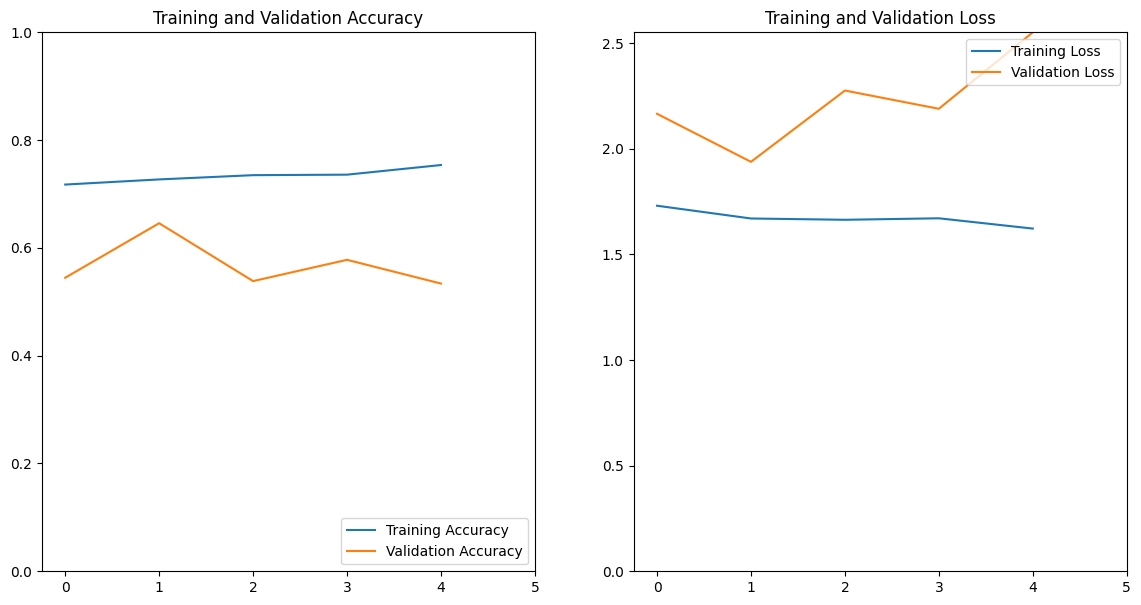

In [65]:
n_epochs = len(history.history['loss'])
print("\nTraining completed in ", n_epochs, "epochs")
print('The Accuracy on Validation Dataset is: %.2f%%'%(np.max(history.history['val_accuracy'])*100))

# Plotting the learning curve
plot_learning_curve(n_epochs, history.history)

### **Testing**

In [66]:
loss, acc = Age_cls_model.evaluate(test_generator, steps=len(data_test), verbose=1)

print(f'Test loss = {loss:.2f}')
print(f'Test Accuracy = {acc*100:.2f}%')

3945/3945 [==============================] - 371s 94ms/step - loss: 1.9016 - accuracy: 0.6646
Tets loss = 1.90
Tets Accuracy = 66.46%


## **Age Regression Model**

In [71]:
# Building the Model

Age_reg_model = tf.keras.Sequential([
    Dense(256, input_shape=(D, D, 3)),

    Conv2D(16, (3, 3), padding="same"),
    Activation("relu"),
    BatchNormalization(axis=-1),

    MaxPooling2D(pool_size=(3, 3)),
    Dropout(0.25),

    Conv2D(32, (3, 3), padding="same"),
    Activation("relu"),
    BatchNormalization(axis=-1),

    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(32, (3, 3), padding="same"),
    Activation("relu"),
    BatchNormalization(axis=-1),

    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),

    Dense(128),
    Activation("relu"),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(1),
    Activation("linear", name="age_output"),

])

Age_reg_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 224, 224, 256)     1024      
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      36880     
                                                                 
 activation (Activation)     (None, 224, 224, 16)      0         
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 dropout_2 (Dropout)         (None, 74, 74, 16)       

In [72]:
init_learning_rate = 1e-4
epochs = 100

optimizer = Adam(learning_rate=init_learning_rate, decay=init_learning_rate/epochs)

Age_reg_model.compile(optimizer=optimizer,
                      loss='mse',
                      loss_weights=4.,
                      metrics='mae')

In [ ]:
batch_size = 32
valid_batch_size = 32

# Applying early-stopping to restore the best weights
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=5,
                                            restore_best_weights=True)

### **Training**

In [74]:
# Training the model
history = Age_reg_model.fit(train_generator,
                            epochs=10,
                            batch_size=batch_size,
                            steps_per_epoch=len(data_train)//batch_size,
                            validation_steps=len(data_val)//batch_size,
                            validation_data=val_generator,
                            callbacks=[callback])

# Saving the Model in a h5 file
Age_reg_model.save('AgeRegressionModel.h5')

Epoch 1/10
998/998 [==============================] - ETA: 0s - loss: 43.6289 - mae: 2.7157

998/998 [==============================] - 328s 328ms/step - loss: 43.6289 - mae: 2.7157 - val_loss: 74.3669 - val_mae: 3.1622
Epoch 2/10
998/998 [==============================] - ETA: 0s - loss: 22.2021 - mae: 1.8312

998/998 [==============================] - 281s 282ms/step - loss: 22.2021 - mae: 1.8312 - val_loss: 867.0416 - val_mae: 6.0615
Epoch 3/10
998/998 [==============================] - ETA: 0s - loss: 14.3834 - mae: 1.4514

998/998 [==============================] - 272s 272ms/step - loss: 14.3834 - mae: 1.4514 - val_loss: 165.4715 - val_mae: 2.8129
Epoch 4/10
998/998 [==============================] - ETA: 0s - loss: 12.1455 - mae: 1.3470

998/998 [==============================] - 273s 274ms/step - loss: 12.1455 - mae: 1.3470 - val_loss: 37.8447 - val_mae: 1.9890
Epoch 5/10
998/998 [==============================] - ETA: 0s - loss: 10.7807 - mae: 1.2741

998/998 [==============================] - 272s 273ms/step - loss: 10.7807 - mae: 1.2741 - val_loss: 65.3613 - val_mae: 1.8503
Epoch 6/10
998/998 [==============================] - ETA: 0s - loss: 9.6662 - mae: 1.2041

998/998 [==============================] - 272s 272ms/step - loss: 9.6662 - mae: 1.2041 - val_loss: 58.4527 - val_mae: 2.1175
Epoch 7/10
998/998 [==============================] - ETA: 0s - loss: 9.2170 - mae: 1.1748

998/998 [==============================] - 273s 273ms/step - loss: 9.2170 - mae: 1.1748 - val_loss: 214.8323 - val_mae: 2.5559
Epoch 8/10
998/998 [==============================] - ETA: 0s - loss: 8.3575 - mae: 1.1189

998/998 [==============================] - 272s 272ms/step - loss: 8.3575 - mae: 1.1189 - val_loss: 364.8235 - val_mae: 4.5967
Epoch 9/10
998/998 [==============================] - ETA: 0s - loss: 8.2600 - mae: 1.1095

998/998 [==============================] - 272s 272ms/step - loss: 8.2600 - mae: 1.1095 - val_loss: 26.4410 - val_mae: 1.5964
Epoch 10/10
998/998 [==============================] - ETA: 0s - loss: 7.7766 - mae: 1.0783

998/998 [==============================] - 273s 273ms/step - loss: 7.7766 - mae: 1.0783 - val_loss: 110.6329 - val_mae: 2.8880


### **Testing**

In [79]:
loss, mae = Age_reg_model.evaluate(test_generator, steps=len(data_test), verbose=1)

print(f'Test loss = {loss:.2f}')
print(f'Test MAE = {mae:.2f}')

3945/3945 [==============================] - 397s 101ms/step - loss: 98.3184 - mae: 2.7861
Test loss = 98.32
Test MAE = 2.79
